In [1]:
import os
import re
import time
import keras
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
RAND_SEED = 12345

N_SAMPLES = 240000
N_CHANNELS = 16

IN_VAL_WAVEFORMS_FILE = 'out/val-waveforms.mem'
IN_VAL_YS_FILE = 'out/val-ys.mem'

N_TRAIN_FILES = 4
IN_TRAIN_WAVEFORMS_FILE = 'out/train-waveforms-%d.mem'
IN_TRAIN_YS_FILE = 'out/train-ys-%d.npy'

MODEL_PATH = 'out/models/b-f%d-e%d-auc%.5f'

In [4]:
np.random.seed(RAND_SEED)

In [5]:
# load validation data
X_val = np.fromfile(IN_VAL_WAVEFORMS_FILE, dtype=np.float32).reshape(-1, N_CHANNELS, N_SAMPLES, 1)
y_val = np.fromfile(IN_VAL_YS_FILE, dtype=np.float32).reshape(-1, 2)

In [6]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout

In [7]:
model = Sequential()

model.add(Convolution2D(
    16, 1, 20, # x, h, w # 50ms
    input_shape=(N_CHANNELS, N_SAMPLES, 1), # 16ch, N_CHw, 1h
    border_mode='valid'
))

model.add(MaxPooling2D(
    (1, 5)
))

model.add(Convolution2D(
    32, 1, 8, # 500ms
    border_mode='valid'
))

model.add(MaxPooling2D(
    (1, 2)
))

model.add(Convolution2D(
    48, 1, 4, # 1000ms
    border_mode='valid'
))

model.add(MaxPooling2D(
    (1, 10)
))

model.add(Convolution2D(
    64, 1, 4, # 10s
    border_mode='valid'
))

model.add(MaxPooling2D(
    (1, 10)
))

model.add(Convolution2D(
    64, 1, 4, # 10s
    border_mode='valid'
))

model.add(MaxPooling2D(
    (1, 2)
))

model.add(Convolution2D(
    64, 4, 4, # 10s
    border_mode='valid'
))

model.add(MaxPooling2D(
    (4, 4)
))

model.add(Flatten())

model.add(Dropout(0.75))

model.add(Dense(128))

model.add(Dense(2, activation='softmax'))

In [8]:
model.output_shape

(None, 2)

In [9]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='RMSprop'
)

In [10]:
def score_auc():
    s = 0
    n = X_val.shape[0]
    
    y_p = model.predict(X_val[s:s+n], verbose=False, batch_size=4)
    y_p = np.nan_to_num(y_p)
    return metrics.roc_auc_score(y_val[s:s+n].T[0], y_p.T[0])

class MyCallback(keras.callbacks.Callback):
    def _validate(self, epoch):
        s = score_auc()
        scores.append(s)
        np.save('out/scores.npy', scores)
        print "\n\n AUC = %.5f\n"%(s)
        if True or len(scores) == 0 or s >= max(scores):
            f = MODEL_PATH%(train_file_n, epoch, s)
            print 'Saving to: ', f, '\n'
            model.save(f)
#     def on_train_begin(self, epoch, logs={}):
#         self._validate(0)
    def on_epoch_end(self, epoch, logs={}):
        self._validate(1 + epoch)

In [11]:
scores = []

In [12]:
for train_file_n in range(N_TRAIN_FILES):

    X_file = IN_TRAIN_WAVEFORMS_FILE%(1 + train_file_n)
    y_file = IN_TRAIN_YS_FILE%(1 + train_file_n)
    
    print 'Using file', X_file, '\n'
    
    X_train = np.memmap(X_file, dtype=np.float32, mode='r+')
    X_train = X_train.reshape(-1, N_CHANNELS, N_SAMPLES, 1)
    y_train = np.fromfile(y_file, dtype=np.float32)
    y_train = y_train.reshape(-1, 2)
    
#     X_train = X_train[:10]
#     y_train = y_train[:10]
    
    model.fit(
        X_train,
        y_train,
        batch_size=4,
        nb_epoch=10,
        validation_data=(X_val, y_val),
        callbacks=[
            MyCallback(),
            keras.callbacks.TensorBoard(log_dir='/tmp/tf-mls', histogram_freq=0, write_graph=True, write_images=False)
        ]
    )

    del X_train
    del y_train

Using file out/train-waveforms-1.mem 

Train on 1375 samples, validate on 642 samples
Epoch 1/10
1372/1375 [============================>.] - ETA: 1s - loss: 0.3606

 AUC = 0.57650

Saving to:  out/models/b-f0-e1-auc0.57650 

1375/1375 [==============================] - 752s - loss: 0.3624 - val_loss: 0.2771
Epoch 2/10
1372/1375 [============================>.] - ETA: 1s - loss: 0.3473

 AUC = 0.51788

Saving to:  out/models/b-f0-e2-auc0.51788 

1375/1375 [==============================] - 767s - loss: 0.3467 - val_loss: 0.2486
Epoch 3/10
1372/1375 [============================>.] - ETA: 1s - loss: 0.3266

 AUC = 0.40441

Saving to:  out/models/b-f0-e3-auc0.40441 

1375/1375 [==============================] - 772s - loss: 0.3293 - val_loss: 0.2667
Epoch 4/10
1372/1375 [============================>.] - ETA: 1s - loss: 0.3254

 AUC = 0.56884

Saving to:  out/models/b-f0-e4-auc0.56884 

1375/1375 [==============================] - 1282s - loss: 0.3251 - val_loss: 0.2590
Epoch 5/10
1372/1

In [14]:
y_p = model.predict(X_val, verbose=True, batch_size=2)
metrics.roc_auc_score(y_val.T[0], y_p.T[0])

642/642 [==============================] - 29s    


0.62390806382730868

In [39]:
ypp=[0. if x < 0.01 else 1. for x in y_p.T[0]]
metrics.roc_auc_score(y_val.T[0], ypp)

0.59257677524556429

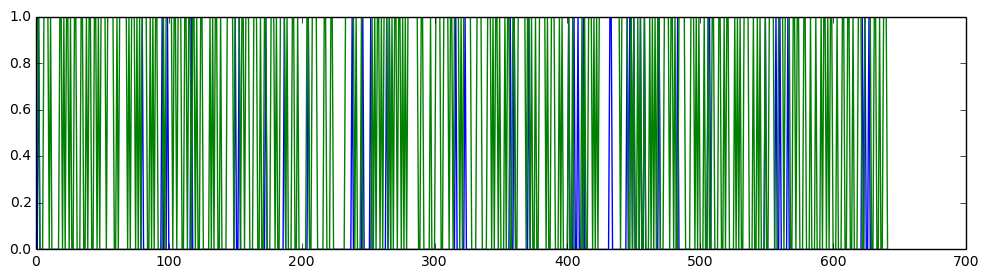

In [40]:
plt.figure(figsize=(12, 3))
plt.plot(y_val.T[0])
# plt.plot(y_p.T[0])
plt.plot(ypp)

(array([ 630.,   12.]),
 array([  1.18017226e-06,   1.45092586e-01,   2.90183991e-01]),
 <a list of 2 Patch objects>)

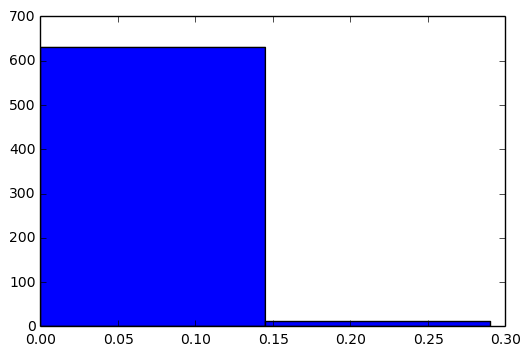

In [41]:
plt.hist(y_p.T[0], bins=2)

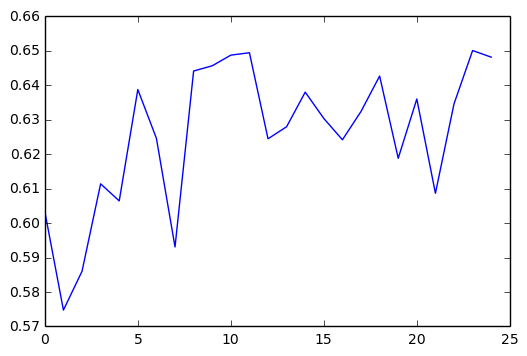

In [24]:
plt.plot(scores)